In [1]:
import numpy as np
from control import lqr, lyap
import matplotlib.pyplot as plt
# import dreal as d

/Users/wangjiarui/miniconda3/envs/ml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def dreal_var(n, name='x'):
    return np.array([d.Variable("%s%d" % (name, i)) for i in range(n)])

def check_lyapunov_lqr(P, K, f, level, lb=0.2, ub=10):
    x = dreal_var(2, 'x')
    u = -K @ x
    x_dot = f(x, u)
    xnorm = d.sqrt(x @ x)
    
    lyapunov_vio = d.And(
        xnorm > lb,
        xnorm < ub,
        x @ P @ x <= level,
        d.Or(
            u[0] < -1,
            u[0] > 1,
            2 * x @ P @ x_dot > 0
        )
    )
    r = d.CheckSatisfiability(lyapunov_vio, 0.001)
    return r


# Inverted Pendulum

In [3]:
g = 9.81
L = 0.5
m = 0.15
b = 0.1

A = np.array([
    [0, 1],
    [g/L, -b/(m * L**2)]
])

B = np.array([
    [0],
    [1/(m * L**2)]
])


K, S, _ = lqr(A, B, np.eye(2), np.eye(1))

def inverted_pendulum_dreal(x, u):
    theta = x[0]
    thetad = x[1]

    
    thetadd = g / L * d.sin(theta) - b / (m * L**2) * thetad + u[0] / (m * L**2)
    return np.stack([thetad, thetadd])

def inverted_pendulum_np(x, u):
    theta = x[:,0]
    thetad = x[:,1]

    
    thetadd = g / L * np.sin(theta) - b / (m * L**2) * thetad + u[:,0] / (m * L**2)
    return np.stack([thetad, thetadd], axis=-1)

# check_lyapunov_lqr(S, K, inverted_pendulum_dreal, 0.1)

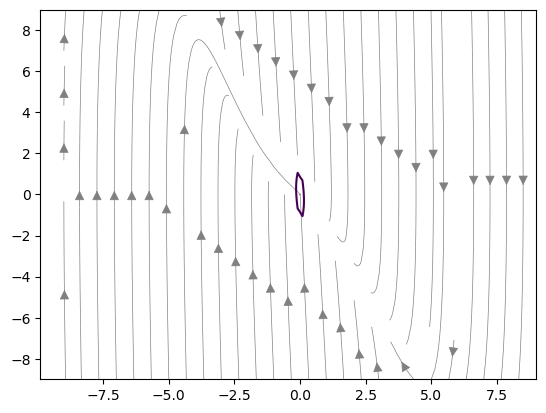

In [4]:
X = np.linspace(-9, 9, 100) 
Y = np.linspace(-9, 9, 100)
x1, x2 = np.meshgrid(X,Y)
Xs = np.stack([x1, x2], axis=2).reshape(-1, 2)
V = np.sum((Xs @ S) * Xs, axis=1).reshape(100, 100)

DXY = inverted_pendulum_np(
    np.stack([x1, x2], axis=2).reshape(-1, 2),
    Xs @ -K.T
)
DXY = DXY.reshape(100, 100, 2)
plt.streamplot(x1,x2, DXY[:,:,0], DXY[:,:,1], color=('gray'), linewidth=0.5,
                  density=0.95, arrowstyle='-|>', arrowsize=1.5)
plt.contour(x1, x2, V, levels=[0.0384])
plt.show()

# Tracking Problem

In [6]:
v = 6.
l = 1.

# Linearized model for tracking problem
A = np.array([
    [0, v],
    [-1, 0]
])

B = np.array([
    [0],
    [v/l]
])

K, S, _ = lqr(A, B, np.eye(2), np.eye(1))
print(K)
print(S)

def tracking_dreal(x, u):
    y1 = v * d.sin(x[1])
    y2 = v * d.tan(u[0]) / l - d.cos(x[1]) / (1 - x[0])
    return np.array([y1, y2])

def tracking_np(x, u):
    y1 = v * np.sin(x[:,1])
    y2 = v * np.tan(u[:,0]) / l - np.cos(x[:,1]) / (1 - x[:,0])
    return np.stack([y1, y2], axis=-1)

# check_lyapunov_lqr(S, K, tracking_dreal, 0.101509)

[[0.84712709 1.64141834]]
[[0.27734328 0.14118785]
 [0.14118785 0.27356972]]


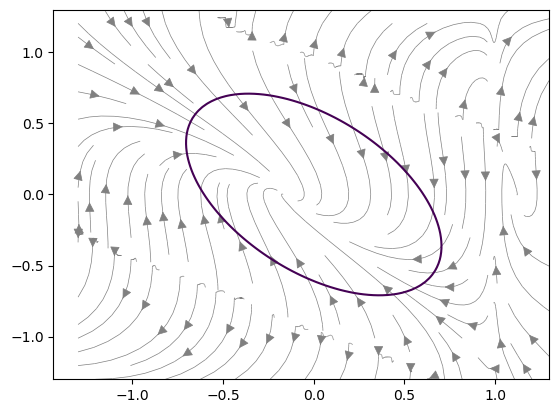

In [7]:
X = np.linspace(-1.3, 1.3, 100) 
Y = np.linspace(-1.3, 1.3, 100)
x1, x2 = np.meshgrid(X,Y)
Xs = np.stack([x1, x2], axis=2).reshape(-1, 2)
V = np.sum((Xs @ S) * Xs, axis=1).reshape(len(X), len(X))

DXY = tracking_np(
    np.stack([x1, x2], axis=2).reshape(-1, 2),
    Xs @ -K.T
)
DXY = DXY.reshape(len(X), len(X), 2)
plt.streamplot(x1,x2, DXY[:,:,0], DXY[:,:,1], color=('gray'), linewidth=0.5,
                  density=0.95, arrowstyle='-|>', arrowsize=1.5)
plt.contour(x1, x2, V, levels=[0.101509])
plt.show()

# Van der Pol

In [8]:
# linearized model for Van der Pol
A = np.array([
    [0, 1],
    [-1, 1.]
])
B = np.array([
    [0],
    [1]
])

Q = np.eye(2)
R = np.eye(1)


K, S, _ = lqr(A, B, np.eye(2), np.eye(1))

def vanderpol_dreal(x, u):
    """
    :param x: np.array[dreal.Variable], [2,]
    :param u: np.array[dreal.Variable], [1,]
    """
    x1 = x[0]
    x2 = x[1]

    x1d = x2
    x2d =  - x1 + (1 - x1 ** 2) * x2 + u[0]

    return np.array([x1d, x2d])

def vanderpol_np(x, u):
    """
    :param x: np.array[dreal.Variable], [2,]
    :param u: np.array[dreal.Variable], [1,]
    """
    x1 = x[:,0]
    x2 = x[:,1]

    x1d = x2
    x2d =  - x1 + (1 - x1 ** 2) * x2 + u[:,0]

    return np.stack([x1d, x2d], axis=-1)

# r = check_lyapunov_lqr(S, K, vanderpol_dreal, 0.37279)
# print(r)

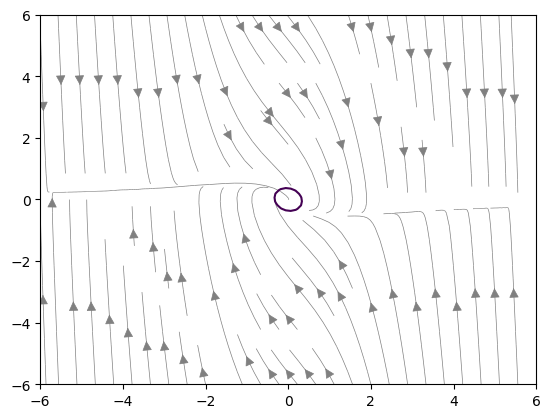

In [9]:
X = np.linspace(-6, 6, 100) 
Y = np.linspace(-6, 6, 100)
x1, x2 = np.meshgrid(X,Y)
Xs = np.stack([x1, x2], axis=2).reshape(-1, 2)
V = np.sum((Xs @ S) * Xs, axis=1).reshape(100, 100)

DXY = vanderpol_np(
    np.stack([x1, x2], axis=2).reshape(-1, 2),
    Xs @ -K.T
)
DXY = DXY.reshape(100, 100, 2)
plt.streamplot(x1,x2, DXY[:,:,0], DXY[:,:,1], color=('gray'), linewidth=0.5,
                  density=0.95, arrowstyle='-|>', arrowsize=1.5)
plt.contour(x1, x2, V, levels=[0.37279])
plt.show()

# Double Integrator

In [11]:
A = np.array([
    [0, 1.],
    [0, 0.]
])
B = np.array([
    [0],
    [1]
])




K, S, _ = lqr(A, B, np.eye(2), np.eye(1))

def double_integrator(x, u):
    """
    :param x: np.array[dreal.Variable], [2,]
    :param u: np.array[dreal.Variable], [1,]
    """
    return np.stack([x[1], u[0]], axis=0)

def double_integrator_np(x, u):
    """
    :param x: np.array[dreal.Variable], [2,]
    :param u: np.array[dreal.Variable], [1,]
    """
    return np.stack([x[:,1], u[:,0]], axis=-1)

# r = check_lyapunov_lqr(S, K, double_integrator, 0.57716)
# print(r)

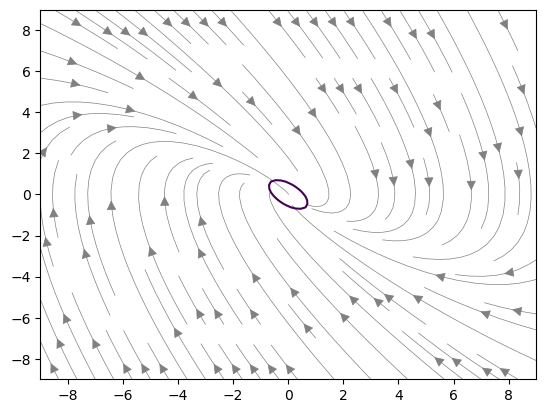

In [12]:
X = np.linspace(-9, 9, 100) 
Y = np.linspace(-9, 9, 100)
x1, x2 = np.meshgrid(X,Y)
Xs = np.stack([x1, x2], axis=2).reshape(-1, 2)
V = np.sum((Xs @ S) * Xs, axis=1).reshape(100, 100)

DXY = double_integrator_np(
    np.stack([x1, x2], axis=2).reshape(-1, 2),
    Xs @ -K.T
)
DXY = DXY.reshape(100, 100, 2)
plt.streamplot(x1,x2, DXY[:,:,0], DXY[:,:,1], color=('gray'), linewidth=0.5,
                  density=0.95, arrowstyle='-|>', arrowsize=1.5)
plt.contour(x1, x2, V, levels=[0.57716])
plt.show()